# 2024 PR Year vs 2025 Injury Year Analysis
## Finding your safe training zone and recovery patterns

Generated by Claude Sonnet 4.5 on 2025-11-21

In [1]:
import sqlite3
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from pathlib import Path
from datetime import datetime, timedelta
import numpy as np

db_path = Path.cwd().parent / "msiysp_dev.db"
conn = sqlite3.connect(db_path)

# Load all running activities
activities = pd.read_sql(
    "SELECT * FROM activities WHERE type = 'Run' ORDER BY date", 
    conn,
    parse_dates=['date']
)

# Calculate derived fields
activities['year'] = activities['date'].dt.year
activities['week'] = activities['date'].dt.isocalendar().week
activities['year_week'] = activities['date'].dt.strftime('%Y-W%U')
activities['distance_miles'] = activities['distance_meters'] / 1609.34
activities['duration_minutes'] = activities['duration_seconds'] / 60
activities['pace_per_mile'] = activities['duration_seconds'] / activities['distance_miles']
activities['pace_minutes'] = activities['pace_per_mile'] / 60
activities['is_race'] = activities['strava_workout_type'] == 1

print(f"Total activities: {len(activities)}")
print(f"Date range: {activities['date'].min()} to {activities['date'].max()}")

Total activities: 1995
Date range: 2019-08-31 20:57:37+00:00 to 2025-11-19 20:33:32+00:00


## 1. Weekly Mileage Pattern: 2024 vs 2025
Your volume consistency and drops

2024 Weekly Mileage:
  Average: 43.3 miles/week
  Median: 46.9 miles/week
  Min: 11.3, Max: 62.3
  Weeks >40 miles: 38 / 53
  Weeks >50 miles: 18 / 53

2025 Weekly Mileage:
  Average: 38.1 miles/week
  Median: 40.7 miles/week
  Min: 15.3, Max: 52.5
  Weeks >40 miles: 24 / 47
  Weeks >50 miles: 2 / 47



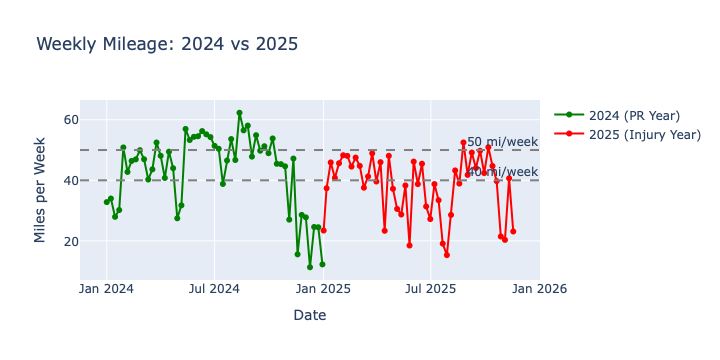

In [2]:
# Weekly mileage for 2024 and 2025
weekly_miles = activities[activities['year'].isin([2024, 2025])].groupby(['year', 'year_week'])['distance_miles'].sum().reset_index()
weekly_miles['week_date'] = pd.to_datetime(weekly_miles['year_week'] + '-1', format='%Y-W%U-%w')

# Separate by year
weekly_2024 = weekly_miles[weekly_miles['year'] == 2024].set_index('week_date')['distance_miles']
weekly_2025 = weekly_miles[weekly_miles['year'] == 2025].set_index('week_date')['distance_miles']

# Stats
print("2024 Weekly Mileage:")
print(f"  Average: {weekly_2024.mean():.1f} miles/week")
print(f"  Median: {weekly_2024.median():.1f} miles/week")
print(f"  Min: {weekly_2024.min():.1f}, Max: {weekly_2024.max():.1f}")
print(f"  Weeks >40 miles: {(weekly_2024 > 40).sum()} / {len(weekly_2024)}")
print(f"  Weeks >50 miles: {(weekly_2024 > 50).sum()} / {len(weekly_2024)}")
print()
print("2025 Weekly Mileage:")
print(f"  Average: {weekly_2025.mean():.1f} miles/week")
print(f"  Median: {weekly_2025.median():.1f} miles/week")
print(f"  Min: {weekly_2025.min():.1f}, Max: {weekly_2025.max():.1f}")
print(f"  Weeks >40 miles: {(weekly_2025 > 40).sum()} / {len(weekly_2025)}")
print(f"  Weeks >50 miles: {(weekly_2025 > 50).sum()} / {len(weekly_2025)}")
print()

# Visualize
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=weekly_2024.index, 
    y=weekly_2024.values, 
    mode='lines+markers',
    name='2024 (PR Year)',
    line=dict(color='green')
))
fig.add_trace(go.Scatter(
    x=weekly_2025.index, 
    y=weekly_2025.values, 
    mode='lines+markers',
    name='2025 (Injury Year)',
    line=dict(color='red')
))
fig.add_hline(y=40, line_dash="dash", line_color="gray", annotation_text="40 mi/week")
fig.add_hline(y=50, line_dash="dash", line_color="gray", annotation_text="50 mi/week")
fig.update_layout(
    title='Weekly Mileage: 2024 vs 2025',
    xaxis_title='Date',
    yaxis_title='Miles per Week',
    hovermode='x unified'
)
fig.show()

## 2. Training Load Before Races
How much were you running in the 8 weeks before each race?

In [3]:
# Get all races in 2024 and 2025
races = activities[(activities['is_race']) & (activities['year'].isin([2024, 2025]))].copy().sort_values('date')

race_prep = []

for idx, race in races.iterrows():
    race_date = race['date']
    
    # Get 8 weeks of training before race (excluding race day)
    eight_weeks_before = race_date - timedelta(days=56)
    training_block = activities[
        (activities['date'] >= eight_weeks_before) & 
        (activities['date'] < race_date) &
        (~activities['is_race'])
    ]
    
    # 4 weeks before
    four_weeks_before = race_date - timedelta(days=28)
    last_four_weeks = activities[
        (activities['date'] >= four_weeks_before) & 
        (activities['date'] < race_date) &
        (~activities['is_race'])
    ]
    
    # Calculate metrics
    total_miles_8wk = training_block['distance_miles'].sum()
    avg_weekly_8wk = total_miles_8wk / 8
    
    total_miles_4wk = last_four_weeks['distance_miles'].sum()
    avg_weekly_4wk = total_miles_4wk / 4
    
    # Longest run in 8 week block
    longest_run = training_block['distance_miles'].max() if len(training_block) > 0 else 0
    
    # Number of 20+ mile runs
    long_runs_20plus = (training_block['distance_miles'] >= 20).sum()
    
    race_prep.append({
        'date': race_date,
        'year': race['year'],
        'race_name': race['name'],
        'race_distance': race['distance_miles'],
        'race_pace': race['pace_minutes'],
        'avg_weekly_miles_8wk': avg_weekly_8wk,
        'avg_weekly_miles_4wk': avg_weekly_4wk,
        'longest_run_8wk': longest_run,
        'long_runs_20plus': long_runs_20plus
    })

prep_df = pd.DataFrame(race_prep)

print("Race Preparation Analysis:")
print(prep_df.round(2).to_string(index=False))
print()

# Compare 2024 vs 2025
print("\n2024 Races (PR Year):")
print(prep_df[prep_df['year'] == 2024][['race_name', 'race_distance', 'race_pace', 'avg_weekly_miles_8wk', 'longest_run_8wk']].round(2).to_string(index=False))
print(f"\nAverage weekly miles (8wk before races): {prep_df[prep_df['year'] == 2024]['avg_weekly_miles_8wk'].mean():.1f}")

print("\n2025 Races (Injury Year):")
print(prep_df[prep_df['year'] == 2025][['race_name', 'race_distance', 'race_pace', 'avg_weekly_miles_8wk', 'longest_run_8wk']].round(2).to_string(index=False))
print(f"\nAverage weekly miles (8wk before races): {prep_df[prep_df['year'] == 2025]['avg_weekly_miles_8wk'].mean():.1f}")

Race Preparation Analysis:
                     date  year                     race_name  race_distance  race_pace  avg_weekly_miles_8wk  avg_weekly_miles_4wk  longest_run_8wk  long_runs_20plus
2024-01-01 16:02:15+00:00  2024                     Lunch Run           6.12       6.36                 40.55                 42.77             8.10                 0
2024-01-21 19:01:14+00:00  2024        Frozen Foot 10K Race 1           6.14       6.46                 36.40                 34.12             8.10                 0
2024-02-18 19:00:34+00:00  2024        Frozen Foot 10K Race 2           6.10       6.39                 37.57                 41.02             8.06                 0
2024-03-16 15:59:46+00:00  2024           Lucky Charm 4 Miler           3.96       6.49                 42.75                 44.18             8.08                 0
2024-04-14 12:00:06+00:00  2024                 Half Marathon          13.27       6.56                 44.88                 46.25       

## 3. Race Spacing and Recovery
How much time between races?

In [4]:
# Calculate days between races
races_sorted = activities[activities['is_race']].sort_values('date')
races_sorted['days_since_last_race'] = races_sorted['date'].diff().dt.days

# Focus on 2024-2025
recent_races = races_sorted[races_sorted['year'].isin([2024, 2025])][['date', 'year', 'name', 'distance_miles', 'pace_minutes', 'days_since_last_race']]

print("Race Calendar with Recovery Time:")
print(recent_races.round(2).to_string(index=False))
print()

print("\nRace Spacing Summary:")
print(f"2024 - Average days between races: {recent_races[recent_races['year'] == 2024]['days_since_last_race'].mean():.0f} days")
print(f"2025 - Average days between races: {recent_races[recent_races['year'] == 2025]['days_since_last_race'].mean():.0f} days")
print()
print("Races with <30 days recovery (risky):")
risky_races = recent_races[recent_races['days_since_last_race'] < 30]
if len(risky_races) > 0:
    print(risky_races[['date', 'name', 'days_since_last_race']].to_string(index=False))
else:
    print("None - good spacing!")

Race Calendar with Recovery Time:
                     date  year                          name  distance_miles  pace_minutes  days_since_last_race
2024-01-01 16:02:15+00:00  2024                     Lunch Run            6.12          6.36                  16.0
2024-01-21 19:01:14+00:00  2024        Frozen Foot 10K Race 1            6.14          6.46                  20.0
2024-02-18 19:00:34+00:00  2024        Frozen Foot 10K Race 2            6.10          6.39                  27.0
2024-03-16 15:59:46+00:00  2024           Lucky Charm 4 Miler            3.96          6.49                  26.0
2024-04-14 12:00:06+00:00  2024                 Half Marathon           13.27          6.56                  28.0
2024-07-17 23:10:01+00:00  2024               Harrisburg Mile            1.00          5.67                  94.0
2024-09-08 12:00:02+00:00  2024 Harrisburg Half Marathon 2024           12.97          6.24                  52.0
2024-11-10 12:31:47+00:00  2024           Harrisburg M

## 4. Training Intensity: Easy vs Moderate Pace
Are you running in the "gray zone" too much in 2025?

Median training pace 2024: 7.80 min/mile
Median training pace 2025: 7.81 min/mile

Training Intensity Distribution (%):
intensity  Easy (>Median)  Hard (<7:30)
year                                   
2024                 84.9          15.1
2025                 83.7          16.3




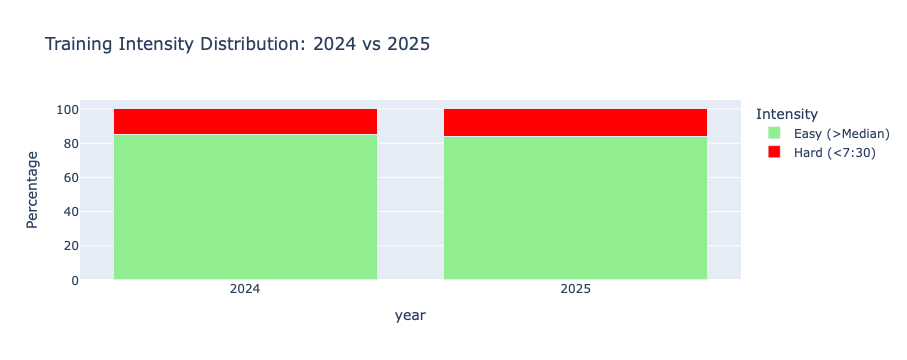

In [5]:
# Exclude races, focus on training runs
training_runs = activities[(~activities['is_race']) & (activities['year'].isin([2024, 2025]))].copy()

# Calculate median pace for each year to set "easy" threshold
median_2024 = training_runs[training_runs['year'] == 2024]['pace_minutes'].median()
median_2025 = training_runs[training_runs['year'] == 2025]['pace_minutes'].median()

print(f"Median training pace 2024: {median_2024:.2f} min/mile")
print(f"Median training pace 2025: {median_2025:.2f} min/mile")
print()

# Categorize runs
def categorize_intensity(row):
    pace = row['pace_minutes']
    year = row['year']
    threshold = median_2024 if year == 2024 else median_2025
    
    if pace < 7.5:  # Fast/workout pace
        return 'Hard (<7:30)'
    elif pace < threshold - 0.5:  # Faster than easy
        return 'Moderate (Gray Zone)'
    else:  # Easy
        return 'Easy (>Median)'

training_runs['intensity'] = training_runs.apply(categorize_intensity, axis=1)

# Count by category
intensity_dist = training_runs.groupby(['year', 'intensity']).size().unstack(fill_value=0)
intensity_pct = intensity_dist.div(intensity_dist.sum(axis=1), axis=0) * 100

print("Training Intensity Distribution (%):")
print(intensity_pct.round(1))
print()

# Check if 2025 has more "moderate" runs
if 'Moderate (Gray Zone)' in intensity_pct.columns:
    gray_2024 = intensity_pct.loc[2024, 'Moderate (Gray Zone)'] if 2024 in intensity_pct.index else 0
    gray_2025 = intensity_pct.loc[2025, 'Moderate (Gray Zone)'] if 2025 in intensity_pct.index else 0
    print(f"Gray zone runs 2024: {gray_2024:.1f}%")
    print(f"Gray zone runs 2025: {gray_2025:.1f}%")
    if gray_2025 > gray_2024 + 5:
        print("⚠️  WARNING: More gray zone running in 2025 - this can lead to fatigue without fitness gains")
print()

# Visualize
fig = px.bar(
    intensity_pct.reset_index().melt(id_vars='year', var_name='Intensity', value_name='Percentage'),
    x='year',
    y='Percentage',
    color='Intensity',
    title='Training Intensity Distribution: 2024 vs 2025',
    barmode='stack',
    color_discrete_map={
        'Easy (>Median)': 'lightgreen',
        'Moderate (Gray Zone)': 'orange',
        'Hard (<7:30)': 'red'
    }
)
fig.show()

## 5. Your "Safe Zone" Rules
Based on 2024 success vs 2025 struggles

In [6]:
# Analyze the successful 2024 races
successful_races_2024 = prep_df[prep_df['year'] == 2024]

# PRs in 2024 (assuming the half and full marathons)
half_marathon_2024 = successful_races_2024[successful_races_2024['race_distance'] > 12].sort_values('race_pace').iloc[0] if len(successful_races_2024[successful_races_2024['race_distance'] > 12]) > 0 else None
full_marathon_2024 = successful_races_2024[successful_races_2024['race_distance'] > 25].sort_values('race_pace').iloc[0] if len(successful_races_2024[successful_races_2024['race_distance'] > 25]) > 0 else None

print("=" * 60)
print("YOUR SAFE ZONE RULES (Based on 2024 PR Year)")
print("=" * 60)
print()

if half_marathon_2024 is not None:
    print("For HALF MARATHON races:")
    print(f"  ✓ 8-week average: >{half_marathon_2024['avg_weekly_miles_8wk']:.0f} miles/week")
    print(f"  ✓ Longest run in prep: {half_marathon_2024['longest_run_8wk']:.1f} miles")
    print(f"  ✓ Race was: {half_marathon_2024['race_name']} at {half_marathon_2024['race_pace']:.2f} min/mile")
    print()

if full_marathon_2024 is not None:
    print("For FULL MARATHON races:")
    print(f"  ✓ 8-week average: >{full_marathon_2024['avg_weekly_miles_8wk']:.0f} miles/week")
    print(f"  ✓ Longest run in prep: {full_marathon_2024['longest_run_8wk']:.1f} miles")
    print(f"  ✓ 20+ mile runs needed: {full_marathon_2024['long_runs_20plus']:.0f}")
    print(f"  ✓ Race was: {full_marathon_2024['race_name']} at {full_marathon_2024['race_pace']:.2f} min/mile")
    print()

print("GENERAL RULES:")
avg_prep_2024 = successful_races_2024['avg_weekly_miles_8wk'].mean()
print(f"  ✓ Average 8-week prep for 2024 races: {avg_prep_2024:.0f} miles/week")
print(f"  ✓ Don't race unless hitting this volume consistently")
print()

# Race spacing
avg_spacing_2024 = recent_races[recent_races['year'] == 2024]['days_since_last_race'].mean()
print(f"  ✓ Minimum recovery between goal races: {avg_spacing_2024:.0f} days")
print(f"  ✓ For marathons: probably need 8-12 weeks")
print()

print("RED FLAGS (What to avoid - from 2025):")
avg_prep_2025 = prep_df[prep_df['year'] == 2025]['avg_weekly_miles_8wk'].mean()
print(f"  ✗ 2025 average prep was only {avg_prep_2025:.0f} miles/week")
print(f"  ✗ Drop of {avg_prep_2024 - avg_prep_2025:.0f} miles/week from 2024")
print(f"  ✗ Don't race when volume drops below {avg_prep_2024 * 0.8:.0f} miles/week")
print()

print("KNEE-SPECIFIC RULES:")
print("  ✓ When knee flares: STOP racing until volume returns")
print("  ✓ Backing off training + racing = injury + poor performance")
print("  ✓ Either train properly OR skip the race")
print("  ✓ Check shoe fit on right foot before every training block")
print()
print("=" * 60)

YOUR SAFE ZONE RULES (Based on 2024 PR Year)

For HALF MARATHON races:
  ✓ 8-week average: >51 miles/week
  ✓ Longest run in prep: 18.2 miles
  ✓ Race was: Harrisburg Half Marathon 2024 at 6.24 min/mile

For FULL MARATHON races:
  ✓ 8-week average: >46 miles/week
  ✓ Longest run in prep: 18.6 miles
  ✓ 20+ mile runs needed: 0
  ✓ Race was: Harrisburg Marathon at 6.65 min/mile

GENERAL RULES:
  ✓ Average 8-week prep for 2024 races: 44 miles/week
  ✓ Don't race unless hitting this volume consistently

  ✓ Minimum recovery between goal races: 41 days
  ✓ For marathons: probably need 8-12 weeks

RED FLAGS (What to avoid - from 2025):
  ✗ 2025 average prep was only 42 miles/week
  ✗ Drop of 2 miles/week from 2024
  ✗ Don't race when volume drops below 35 miles/week

KNEE-SPECIFIC RULES:
  ✓ When knee flares: STOP racing until volume returns
  ✓ Backing off training + racing = injury + poor performance
  ✓ Either train properly OR skip the race
  ✓ Check shoe fit on right foot before every t

## 6. 2026 Race Planning
Build your calendar with these constraints

In [ ]:
print("2026 RACE PLANNING GUIDE")
print("=" * 60)
print()
print("Based on your data:")
print()
print("1. ANNUAL RACE LIMIT: 6-8 races total")
print("   - 2024 (successful): 8 races")
print("   - 2025 (injury): 4 races (but on reduced training)")
print("   - Sweet spot: 6-8 races with proper prep")
print()
print("2. GOAL RACE SPACING:")
print("   - Half marathons: 8+ weeks apart")
print("   - Full marathons: 12+ weeks apart")
print("   - Fun races/5Ks: okay to fill gaps if volume is solid")
print()
print("3. TRAINING BLOCK REQUIREMENTS:")
if full_marathon_2024 is not None:
    print(f"   - Marathon: {full_marathon_2024['avg_weekly_miles_8wk']:.0f}+ miles/week for 8+ weeks")
if half_marathon_2024 is not None:
    print(f"   - Half marathon: {half_marathon_2024['avg_weekly_miles_8wk']:.0f}+ miles/week for 8+ weeks")
print("   - No racing if weekly average drops below threshold")
print()
print("4. INJURY PREVENTION:")
print("   - Weekly mileage changes: max 10% increase per week")
print("   - If knee acts up: reduce volume, skip next race")
print("   - Don't try to 'race into shape' - it doesn't work")
print()
print("5. SAMPLE 2026 CALENDAR:")
print("   - Winter: Build base, maybe 1-2 fun races")
print("   - Spring: Goal race #1 (half or full)")
print("   - Summer: Maintenance + 1-2 shorter races")
print("   - Fall: Goal race #2 (half or full)")
print("   - Late Fall: 1-2 fun races if feeling good")
print()
print("=" * 60)